# Autoencoder

The architecture consists of an Encoder and a Decoder module. The Encoder compress the data into an abstract representation in a lower-dimensional space (the latent space) and the Decoder decompress the encoded information and reconstruct the data. 

The goal of an Autoencoder is to learn a compressed representation of the input data, focusing on minimizing the reconstruction error (the difference between the original input and the reconstruction).

see: Mark Liu, "Learn Generative AI with PyTorch", Chapter 7.2 

In [1]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as T

from torchvision.datasets import MNIST

## Load MNIST data

In [2]:
transform = T.Compose([T.ToTensor()])

train_set = MNIST("./data", train=True, download=True, transform=transform) 
test_set = MNIST("./data", train=False, download=True, transform=transform) 

In [3]:
for example in iter(train_set):
    print(example[0].size(), example[1])
    break


torch.Size([1, 28, 28]) 5


In [4]:
#create batches with 32 images per batch
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

## Train and Build an Autoencoder

In [5]:
import torch.nn.functional as F

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

class AE(nn.Module):
    def __init__(self, input_dim, z_dim, h_dim):
        super().__init__()
        self.encoder_layer1 = nn.Linear(input_dim, h_dim)
        self.encoder_layer2 = nn.Linear(h_dim, z_dim)
        self.decoder_layer1 = nn.Linear(z_dim, h_dim)
        self.decoder_layer2 = nn.Linear(h_dim, input_dim)
        
    def encode(self, x):
        h = F.relu(self.encoder_layer1(x))
        return self.encoder_layer2(h)

    def decode(self, z):
        h = F.relu(self.decoder_layer1(z))
        return torch.sigmoid(self.decoder_layer2(h))

    def forward(self, x):
        z = self.encode(x)
        o = self.decode(z)
        return z, o


mps


In [6]:
# hyperparameter
input_dim = 784
z_dim = 20
h_dim = 200

model = AE(input_dim, z_dim, h_dim).to(device)
model

AE(
  (encoder_layer1): Linear(in_features=784, out_features=200, bias=True)
  (encoder_layer2): Linear(in_features=200, out_features=20, bias=True)
  (decoder_layer1): Linear(in_features=20, out_features=200, bias=True)
  (decoder_layer2): Linear(in_features=200, out_features=784, bias=True)
)

In [7]:
lr = 0.00025
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [8]:
##### plotting the digits #######
import matplotlib.pyplot as plt
originals = []
idx = 0
for img, label in test_set:
    if label == idx:
        originals.append(img)
        idx += 1
    if idx == 10:
        break
print(len(originals))
def plot_digits():
    reconstructed = []
    for idx in range(10):
        with torch.no_grad():
            img = originals[idx].reshape((1,input_dim))
            z, o = model(img.to(device))
        reconstructed.append(o)
    imgs = originals+reconstructed
    plt.figure(figsize=(10,2), dpi=50)
    for i in range(20):
        ax = plt.subplot(2, 10, i+1)
        img = (imgs[i]).detach().cpu().numpy()
        plt.imshow(img.reshape(28,28), cmap="binary")
        plt.xticks([])
        plt.yticks([])
    plt.show()

10


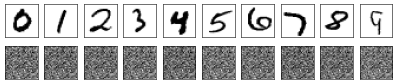

In [9]:
plot_digits()

## Traing Loop

epoch 0: total_loss = 1013.3169098144531


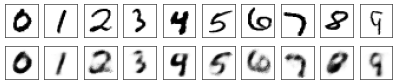

epoch 1: total_loss = 1484.5917928710937


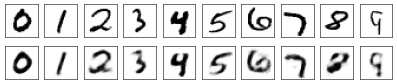

epoch 2: total_loss = 1864.9542216145833


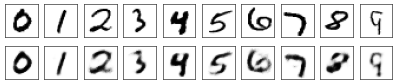

epoch 3: total_loss = 2211.1797810709636


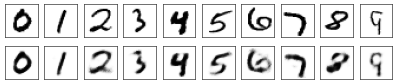

epoch 4: total_loss = 2535.548705965169


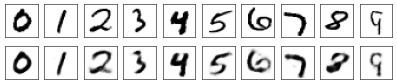

epoch 5: total_loss = 2843.6226428629557


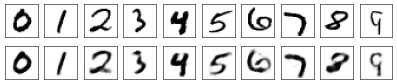

epoch 6: total_loss = 3138.6519599283856


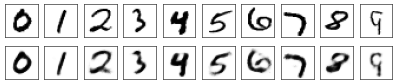

epoch 7: total_loss = 3422.5859247477215


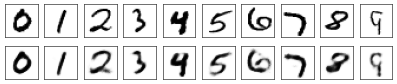

epoch 8: total_loss = 3697.2801347005206


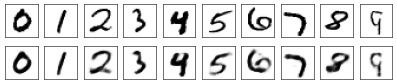

epoch 9: total_loss = 3964.1450795166015


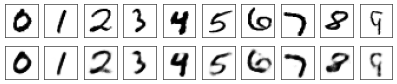

In [10]:
total_loss = 0
for epoch in range(10):
    for images, labels in train_loader:
        images = images.to(device).view(-1, input_dim) # flatten the image
        z, o = model(images)
        loss = ((o-images)**2).sum() # reconstruction loss as measured by mean squared error
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"epoch {epoch}: total_loss = {total_loss/len(train_loader)}")
    plot_digits()